In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')



In [2]:
# --- CONFIGURATION ---
INITIAL_CAPITAL = 100000
START_DATE = "2020-01-01"
END_DATE = "2024-10-31"
TICKERS = ["SPY", "QQQ"] 
BENCHMARK_TICKER = "SPY"
N_SIMULATIONS = 1000  # Increased for better sampling

# --- FIXED: MORE REASONABLE RISK MANAGEMENT ---
COMMISSION_RATE = 0.00005  # 0.005% per trade (was too high at 0.1%)
SLIPPAGE_RATE = 0.0001    # 0.01% slippage (was too high)
MAX_POSITION_SIZE = 1.0   # Use 100% of capital (was limiting too much)
STOP_LOSS_PCT = 0.05      # 5% stop loss (3% was too tight for mean reversion)
TRAILING_STOP_PCT = 0.07  # 7% trailing stop (was too tight)
MAX_RISK_PER_TRADE = 1 # Risk 10% per trade (2% was too conservative)
USE_KELLY_SIZING = False  # Disable Kelly initially - it needs more trades
USE_STOP_LOSSES = True    # Toggle stops on/off

# Global dictionaries to store data for reuse
data_dict = {}
best_returns_data = {} 



In [3]:
# ==================== RSI CALCULATION ====================
def calculate_rsi(data, period=2):
    """Calculate RSI indicator"""
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss.replace(0, np.nan) 
    rsi = 100 - (100 / (1 + rs))
    return rsi



In [4]:
# ==================== KELLY CRITERION POSITION SIZING ====================
def calculate_kelly_fraction(win_rate, avg_win, avg_loss):
    """Calculate Kelly Criterion for optimal position sizing."""
    if avg_loss == 0 or win_rate == 0 or avg_win <= 0:
        return 0.5  # Default to 50% if insufficient data
    
    win_loss_ratio = abs(avg_win / avg_loss)
    kelly = win_rate - ((1 - win_rate) / win_loss_ratio)
    
    # Cap Kelly between 10% and 100% for safety
    return max(0.1, min(kelly * 0.5, 1.0))  # Half-Kelly



In [5]:
# ==================== BACKTEST  ====================
def backtest_rsi_strategy(data, rsi_period, rsi_buy, rsi_sell, sma_period, ticker, 
                          return_returns=False, use_risk_mgmt=True):
    """
    FIXED backtest with proper mean reversion logic and realistic costs
    IMPROVED: Assumes uptrend until SMA is available (no waiting period)
    """
    df = data.copy()
    
    # Handle yfinance multi-index columns (e.g., ('Close', 'SPY'))
    if isinstance(df.columns, pd.MultiIndex):
        # Flatten multi-index by taking first level
        df.columns = df.columns.get_level_values(0)
    
    # Ensure 'Close' column exists
    if 'Close' not in df.columns:
        # If data is a Series or single column, rename it
        if len(df.columns) == 1:
            df.columns = ['Close']
        else:
            raise ValueError(f"Cannot find 'Close' column in data. Columns: {df.columns.tolist()}")
    
    # Calculate indicators
    df['RSI'] = calculate_rsi(df, rsi_period)
    df['SMA'] = df['Close'].rolling(window=sma_period).mean()
    
    # CRITICAL FIX: Forward-fill SMA with current price until enough data
    # This means: assume we're in uptrend until proven otherwise
    for i in range(len(df)):
        if pd.isna(df['SMA'].iloc[i]):
            df.loc[df.index[i], 'SMA'] = df['Close'].iloc[i]
    
    # Only drop rows where RSI is NaN (much fewer rows)
    df = df.dropna(subset=['RSI'])
    
    if len(df) < 50:  # Reduced minimum from 100
        return None
    
    # Trade tracking
    position = 0
    total_trades = 0
    winning_trades = 0
    losing_trades = 0
    trade_pnls = []
    holding_periods = []
    
    # Portfolio state
    equity = [INITIAL_CAPITAL]
    cash = INITIAL_CAPITAL
    shares = 0
    entry_price = 0
    highest_price_since_entry = 0
    entry_date_idx = 0
    equity_dates = [df.index[0]]
    
    # Kelly sizing parameters
    kelly_fraction = 0.5
    win_rate = 0.5
    avg_win = 0.02
    avg_loss = -0.01
    
    for i in range(1, len(df)):
        current_price = df['Close'].iloc[i].item() 
        rsi = df['RSI'].iloc[i].item()
        sma = df['SMA'].iloc[i].item()
        in_uptrend = current_price > sma
        current_equity = (shares * current_price) + cash
        
        # === CHECK STOPS (if enabled) ===
        if position == 1 and use_risk_mgmt and USE_STOP_LOSSES:
            if current_price > highest_price_since_entry:
                highest_price_since_entry = current_price
            
            stop_loss_price = entry_price * (1 - STOP_LOSS_PCT)
            trailing_stop_price = highest_price_since_entry * (1 - TRAILING_STOP_PCT)
            
            if current_price <= stop_loss_price or current_price <= trailing_stop_price:
                # SELL - Stop Hit
                gross_proceeds = shares * current_price
                commission = gross_proceeds * COMMISSION_RATE
                slippage = gross_proceeds * SLIPPAGE_RATE
                net_proceeds = gross_proceeds - commission - slippage
                
                trade_pnl = (net_proceeds - (entry_price * shares)) / (entry_price * shares)
                trade_pnls.append(trade_pnl)
                
                cash = net_proceeds
                
                if trade_pnl > 0:
                    winning_trades += 1
                else:
                    losing_trades += 1
                
                holding_periods.append(i - entry_date_idx)
                shares = 0
                position = 0
                total_trades += 1
                
                # Update Kelly
                if len(trade_pnls) >= 20:
                    wins = [p for p in trade_pnls if p > 0]
                    losses = [p for p in trade_pnls if p < 0]
                    if wins and losses:
                        win_rate = len(wins) / len(trade_pnls)
                        avg_win = np.mean(wins)
                        avg_loss = np.mean(losses)
                        kelly_fraction = calculate_kelly_fraction(win_rate, avg_win, avg_loss)
        
        # === BUY SIGNAL: RSI oversold AND in uptrend ===
        if position == 0 and rsi < rsi_buy and in_uptrend:
            # Position sizing
            if use_risk_mgmt and USE_KELLY_SIZING and len(trade_pnls) >= 20:
                position_size = kelly_fraction
            elif use_risk_mgmt:
                # Fixed fractional based on stop loss
                position_size = MAX_RISK_PER_TRADE / STOP_LOSS_PCT if USE_STOP_LOSSES else 1.0
            else:
                position_size = 1.0
            
            position_size = min(position_size, MAX_POSITION_SIZE)
            capital_to_use = cash * position_size
            
            # BUY with costs
            commission = capital_to_use * COMMISSION_RATE
            slippage = capital_to_use * SLIPPAGE_RATE
            net_capital = capital_to_use - commission - slippage
            
            if net_capital > 0 and net_capital <= cash:
                shares = net_capital / current_price
                cash -= capital_to_use
                entry_price = current_price
                highest_price_since_entry = current_price
                entry_date_idx = i
                position = 1
        
        # === SELL SIGNAL: RSI overbought OR trend break ===
        elif position == 1:
            should_sell = False
            
            # Exit if RSI reaches overbought
            if rsi > rsi_sell:
                should_sell = True
            
            # Exit if trend breaks (price falls below SMA)
            if not in_uptrend:
                should_sell = True
            
            if should_sell:
                # SELL with costs
                gross_proceeds = shares * current_price
                commission = gross_proceeds * COMMISSION_RATE
                slippage = gross_proceeds * SLIPPAGE_RATE
                net_proceeds = gross_proceeds - commission - slippage
                
                trade_pnl = (net_proceeds - (entry_price * shares)) / (entry_price * shares)
                trade_pnls.append(trade_pnl)
                
                cash = net_proceeds
                
                if trade_pnl > 0:
                    winning_trades += 1
                else:
                    losing_trades += 1
                
                holding_periods.append(i - entry_date_idx)
                shares = 0
                position = 0
                total_trades += 1
                
                # Update Kelly
                if len(trade_pnls) >= 20:
                    wins = [p for p in trade_pnls if p > 0]
                    losses = [p for p in trade_pnls if p < 0]
                    if wins and losses:
                        win_rate = len(wins) / len(trade_pnls)
                        avg_win = np.mean(wins)
                        avg_loss = np.mean(losses)
                        kelly_fraction = calculate_kelly_fraction(win_rate, avg_win, avg_loss)
        
        # Calculate daily equity
        current_equity = (shares * current_price) + cash
        equity.append(current_equity)
        equity_dates.append(df.index[i])
    
    # Final position cleanup
    if position == 1:
        final_price = df['Close'].iloc[-1].item()
        gross_proceeds = shares * final_price
        commission = gross_proceeds * COMMISSION_RATE
        slippage = gross_proceeds * SLIPPAGE_RATE
        net_proceeds = gross_proceeds - commission - slippage
        
        trade_pnl = (net_proceeds - (entry_price * shares)) / (entry_price * shares)
        trade_pnls.append(trade_pnl)
        
        cash = net_proceeds
        
        if trade_pnl > 0:
            winning_trades += 1
        else:
            losing_trades += 1
        
        holding_periods.append(len(df) - 1 - entry_date_idx)
        total_trades += 1
    
    # Returns calculation
    equity_series = pd.Series(equity, index=equity_dates)
    returns = equity_series.pct_change().fillna(0)
    
    if return_returns:
        return returns
    
    # Calculate metrics
    if len(returns) == 0 or total_trades == 0:
        return None
    
    final_equity = equity[-1]
    total_return = (final_equity - INITIAL_CAPITAL) / INITIAL_CAPITAL 
    
    # Sharpe Ratio
    if returns.std() != 0:
        sharpe = (returns.mean() / returns.std()) * np.sqrt(252)
    else:
        sharpe = 0
    
    # Max Drawdown
    equity_curve = pd.Series(equity, index=equity_dates)
    cummax = equity_curve.cummax()
    drawdown = (equity_curve / cummax - 1)
    max_drawdown = drawdown.min()
    
    # Performance metrics
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    wins = [p for p in trade_pnls if p > 0]
    losses = [p for p in trade_pnls if p < 0]
    avg_win = np.mean(wins) if wins else 0
    avg_loss = np.mean(losses) if losses else 0
    
    profit_factor = sum(wins) / abs(sum(losses)) if losses else (10 if wins else 0)
    avg_holding_days = np.mean(holding_periods) if holding_periods else 0
    
    return {
        'ticker': ticker,
        'rsi_period': rsi_period,
        'rsi_buy': rsi_buy,
        'rsi_sell': rsi_sell,
        'sma_period': sma_period,
        'total_return': total_return,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown,
        'total_trades': total_trades,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'profit_factor': profit_factor,
        'avg_holding_days': avg_holding_days,
    }



In [6]:
# ==================== MONTE CARLO OPTIMIZATION ====================
def monte_carlo_optimization(data_dict, n_simulations):
    """Run Monte Carlo simulation with EXPANDED parameter ranges"""
    print(f"Running {n_simulations} Monte Carlo simulations...")
    all_results = []
    
    # EXPANDED RANGES for better exploration
    rsi_periods = [2, 3, 4, 5, 6, 7, 8, 10, 12, 14]  # More options
    rsi_buy_range = range(10, 41, 1)   # 10-40 (higher for mean reversion)
    rsi_sell_range = range(60, 91, 1)  # 60-90 (lower for exits)
    sma_periods = [20, 50, 100, 150, 200]  # Added shorter SMA
    
    for ticker, data in data_dict.items():
        print(f"Optimizing for {ticker}...")
        ticker_results = []
        
        for sim in range(n_simulations):
            rsi_period = np.random.choice(rsi_periods)
            rsi_buy = np.random.choice(rsi_buy_range)
            rsi_sell = np.random.choice(rsi_sell_range)
            sma_period = np.random.choice(sma_periods)
            
            if rsi_buy >= rsi_sell - 10:  # Ensure at least 10 point gap
                continue
            
            result = backtest_rsi_strategy(data, rsi_period, rsi_buy, rsi_sell, 
                                          sma_period, ticker, use_risk_mgmt=True)
            
            if result and result['total_trades'] >= 10:  # Require more trades
                ticker_results.append(result)
        
        # Only keep strategies with positive Sharpe
        positive_sharpe = [r for r in ticker_results if r['sharpe_ratio'] > 0]
        
        if len(positive_sharpe) > 0:
            all_results.extend(positive_sharpe)
            print(f"  ✓ Found {len(positive_sharpe)} profitable strategies for {ticker}")
        else:
            print(f"  No profitable strategies found for {ticker}")
                 
    return pd.DataFrame(all_results)



In [7]:
# ==================== MAIN EXECUTION ====================

print(" Downloading data...")
for ticker in TICKERS + [BENCHMARK_TICKER]:
    data = yf.download(ticker, start=START_DATE, end=END_DATE, progress=False)
    if not data.empty:
        data_dict[ticker] = data
        print(f"  ✓ {ticker}: {len(data)} days")

print("\n Configuration:")
print(f"  • Commission: {COMMISSION_RATE*100:.2f}%")
print(f"  • Slippage: {SLIPPAGE_RATE*100:.2f}%")
print(f"  • Stop Loss: {STOP_LOSS_PCT*100:.0f}% ({'ENABLED' if USE_STOP_LOSSES else 'DISABLED'})")
print(f"  • Position Sizing: {'Kelly Criterion' if USE_KELLY_SIZING else 'Fixed Risk'}")
print(f"  • Min Trades Required: 10")

# Run optimization
mc_results = monte_carlo_optimization(data_dict, N_SIMULATIONS)

# Identify best strategies
if len(mc_results) > 0:
    final_strategies = pd.DataFrame()
    
    for ticker in TICKERS:
        ticker_results = mc_results[mc_results['ticker'] == ticker]
        if ticker_results.empty:
            print(f"No valid strategies for {ticker}")
            continue
        
        # Filter: Only strategies with Sharpe > 0.5 and positive returns
        good_strategies = ticker_results[
            (ticker_results['sharpe_ratio'] > 0.5) & 
            (ticker_results['total_return'] > 0)
        ]
        
        if good_strategies.empty:
            print(f"No profitable strategies for {ticker}")
            continue
            
        # Strategy 1: Max Sharpe Ratio
        best_sharpe = good_strategies.loc[good_strategies['sharpe_ratio'].idxmax()].copy()
        best_sharpe['Strategy_Type'] = 'Max Sharpe'
        
        # Strategy 2: Max Total Return (if different)
        best_return = good_strategies.loc[good_strategies['total_return'].idxmax()].copy()
        best_return['Strategy_Type'] = 'Max Return'
        
        is_duplicate = (best_sharpe['rsi_period'] == best_return['rsi_period'] and 
                        best_sharpe['rsi_buy'] == best_return['rsi_buy'] and
                        best_sharpe['rsi_sell'] == best_return['rsi_sell'] and
                        best_sharpe['sma_period'] == best_return['sma_period'])
        
        if not is_duplicate:
            final_strategies = pd.concat([final_strategies, best_sharpe.to_frame().T, 
                                         best_return.to_frame().T], ignore_index=True)
        else:
            final_strategies = pd.concat([final_strategies, best_sharpe.to_frame().T], 
                                        ignore_index=True)

    if len(final_strategies) > 0:
        # Coerce numeric columns
        numeric_cols = ['sharpe_ratio', 'total_return', 'max_drawdown', 'rsi_period', 
                        'rsi_buy', 'rsi_sell', 'sma_period', 'total_trades', 'win_rate',
                        'avg_win', 'avg_loss', 'profit_factor', 'avg_holding_days']
        for col in numeric_cols:
            if col in final_strategies.columns:
                final_strategies[col] = pd.to_numeric(final_strategies[col], errors='coerce')

        print("\n" + "=" * 90)
        print("OPTIMIZATION COMPLETE - PROFITABLE STRATEGIES FOUND:")
        print("=" * 90)
        
        display_cols = ['ticker', 'Strategy_Type', 'sharpe_ratio', 'total_return', 
                        'max_drawdown', 'win_rate', 'profit_factor', 'total_trades',
                        'rsi_period', 'rsi_buy', 'rsi_sell', 'sma_period']
        print(final_strategies[display_cols].sort_values(['ticker', 'Strategy_Type'])
              .to_string(index=False, float_format="%.3f"))
        
        # Prepare data for visualization
        print("\n Preparing visualization data...")
        for index, row in final_strategies.iterrows():
            ticker = row['ticker']
            strategy_type = row['Strategy_Type']
            
            daily_returns = backtest_rsi_strategy(
                data_dict[ticker], 
                int(row['rsi_period']), 
                int(row['rsi_buy']), 
                int(row['rsi_sell']), 
                int(row['sma_period']), 
                ticker, 
                return_returns=True,
                use_risk_mgmt=True
            )
            
            if daily_returns is not None:
                if ticker not in best_returns_data:
                    best_returns_data[ticker] = {}
                best_returns_data[ticker][strategy_type] = daily_returns
            
        print("Ready for visualization!")
    else:
        print("\n No profitable strategies found after filtering!")
        print("   Try adjusting parameters or disable stops with USE_STOP_LOSSES = False")
else:
    print("\n No valid results. Strategy may not be profitable in this period.")

  ✓ SPY: 1216 days
  ✓ QQQ: 1216 days
  ✓ SPY: 1216 days

 Configuration:
  • Commission: 0.01%
  • Slippage: 0.01%
  • Stop Loss: 5% (ENABLED)
  • Position Sizing: Fixed Risk
  • Min Trades Required: 10
Running 1000 Monte Carlo simulations...
Optimizing for SPY...
  ✓ Found 582 profitable strategies for SPY
Optimizing for QQQ...
  ✓ Found 588 profitable strategies for QQQ

OPTIMIZATION COMPLETE - PROFITABLE STRATEGIES FOUND:
ticker Strategy_Type  sharpe_ratio  total_return  max_drawdown  win_rate  profit_factor  total_trades  rsi_period  rsi_buy  rsi_sell  sma_period
   QQQ    Max Sharpe         1.534         1.023        -0.095     0.672          2.558            58           4       35        77          50
   SPY    Max Sharpe         1.727         1.076        -0.082     0.761          3.199            67           2       31        79         150

 Preparing visualization data...
Ready for visualization!


In [16]:
# ==================== IMPROVED WALK-FORWARD ANALYSIS ====================
def walk_forward_analysis(data, strategy_params, ticker, n_splits=8):
    """
    Walk-forward optimization with IMPROVED data handling.
    Ensures sufficient lookback for all indicators.
    """
    print(f"\n Running Walk-Forward Analysis for {ticker}...")
    print(f"   Data range: {data.index[0].date()} to {data.index[-1].date()} ({len(data)} days)")
    
    # 1. Determine Indicator Lookback Requirement
    rsi_period = int(strategy_params.get('rsi_period', 4))
    sma_period = int(strategy_params.get('sma_period', 100))
    max_lookback = max(rsi_period, sma_period)
    
    # CRITICAL: Add buffer for indicator calculation (20% extra)
    lookback_buffer = int(max_lookback * 1.2)
    
    print(f"   Required lookback: {max_lookback} days (using {lookback_buffer} with buffer)")
    
    # 2. Dynamic window sizing based on available data
    total_days = len(data)
    
    # Ensure we have enough data for lookback + reasonable test windows
    min_required = lookback_buffer + 60  # At minimum need lookback + 2 months
    
    if total_days < min_required:
        print(f"    Insufficient total data: need {min_required}, have {total_days}")
        return pd.DataFrame()
    
    # Adjust window sizes based on available data
    available_for_analysis = total_days - lookback_buffer
    
    if available_for_analysis < 150:
        train_days = 40   # ~2 months
        test_days = 10    # ~2 weeks
        step_size = 10
        print(f"   Using SMALL windows (limited data)")
    elif available_for_analysis < 300:
        train_days = 60   # ~3 months
        test_days = 20    # ~1 month
        step_size = 20
        print(f"   Using MEDIUM windows")
    else:
        train_days = 90   # ~4 months
        test_days = 21    # ~1 month
        step_size = 21
        print(f"   Using STANDARD windows")
    
    print(f"   Train: {train_days} days, Test: {test_days} days, Step: {step_size} days")
    
    # Calculate max possible splits
    max_splits = (available_for_analysis - train_days) // step_size
    n_splits = min(n_splits, max_splits)
    
    if n_splits < 1:
        print(f"    Cannot create even 1 split with current data")
        return pd.DataFrame()
    
    print(f"   Will create {n_splits} splits (max possible: {max_splits})")
    
    # Get strategy info
    print(f"   Strategy: RSI({rsi_period}) Buy<{int(strategy_params['rsi_buy'])} "
          f"Sell>{int(strategy_params['rsi_sell'])} SMA({sma_period})")
    print(f"   In-sample trades: {int(strategy_params['total_trades'])}")
    
    results = []
    successful_splits = 0
    
    for split in range(n_splits):
        # Start AFTER the lookback buffer
        start_idx = lookback_buffer + (split * step_size)
        end_train = start_idx + train_days
        end_test = end_train + test_days
        
        if end_test > total_days:
            print(f"   Split {split + 1}: Reached end of data")
            break
        
        # IMPORTANT: Include lookback BEFORE the train/test windows
        # This ensures indicators can be calculated properly
        
        # For training: include lookback before start_idx
        train_start_with_lookback = start_idx - lookback_buffer
        train_data_with_lookback = data.iloc[train_start_with_lookback:end_train]
        
        # For testing: include lookback before end_train
        test_start_with_lookback = end_train - lookback_buffer
        test_data_with_lookback = data.iloc[test_start_with_lookback:end_test]
        
        # Net windows (for reporting only)
        train_data_net = data.iloc[start_idx:end_train]
        test_data_net = data.iloc[end_train:end_test]
        
        # Validation checks
        if len(train_data_with_lookback) < (lookback_buffer + 30):
            print(f"   Split {split + 1}: Train data too short (need {lookback_buffer + 30}, have {len(train_data_with_lookback)})")
            continue
        
        if len(test_data_with_lookback) < (lookback_buffer + 10):
            print(f"   Split {split + 1}: Test data too short (need {lookback_buffer + 10}, have {len(test_data_with_lookback)})")
            continue
        
        print(f"   Split {split + 1}: Train {train_data_net.index[0].date()} to {train_data_net.index[-1].date()}, "
              f"Test {test_data_net.index[0].date()} to {test_data_net.index[-1].date()}")
        print(f"      (With lookback: Train={len(train_data_with_lookback)} days, Test={len(test_data_with_lookback)} days)")
        
        # Run backtest on test data
        test_result = backtest_rsi_strategy(
            test_data_with_lookback,
            rsi_period,
            int(strategy_params['rsi_buy']),
            int(strategy_params['rsi_sell']),
            sma_period,
            ticker,
            use_risk_mgmt=True
        )
        
        if test_result is not None:
            successful_splits += 1
            num_trades = test_result['total_trades']
            
            if num_trades == 0:
                print(f"       No trades - Strategy stayed out")
                results.append({
                    'split': split + 1,
                    'train_start': train_data_net.index[0],
                    'train_end': train_data_net.index[-1],
                    'test_start': test_data_net.index[0],
                    'test_end': test_data_net.index[-1],
                    'sharpe': 0,
                    'total_return': 0,
                    'max_drawdown': 0,
                    'win_rate': 0,
                    'profit_factor': 0,
                    'trades': 0
                })
            else:
                results.append({
                    'split': split + 1,
                    'train_start': train_data_net.index[0],
                    'train_end': train_data_net.index[-1],
                    'test_start': test_data_net.index[0],
                    'test_end': test_data_net.index[-1],
                    'sharpe': test_result['sharpe_ratio'],
                    'total_return': test_result['total_return'],
                    'max_drawdown': test_result['max_drawdown'],
                    'win_rate': test_result['win_rate'],
                    'profit_factor': test_result['profit_factor'],
                    'trades': num_trades
                })
                print(f"      ✓ Sharpe: {test_result['sharpe_ratio']:.2f}, "
                      f"Return: {test_result['total_return']*100:.1f}%, "
                      f"Trades: {num_trades}")
        else:
            print(f"      ✗ Backtest failed (this should rarely happen now)")
    
    if len(results) == 0:
        print(f"\n    No valid walk-forward splits generated")
        print(f"   Attempted: {n_splits}, Successful: {successful_splits}")
        return pd.DataFrame()
    
    print(f"\n   ✓ Generated {len(results)} valid splits (attempted {n_splits}, success rate: {len(results)/n_splits*100:.0f}%)")
    
    # Calculate performance metrics
    results_df = pd.DataFrame(results)
    avg_oos_sharpe = results_df['sharpe'].mean()
    std_oos_sharpe = results_df['sharpe'].std()
    in_sample_sharpe = strategy_params.get('sharpe_ratio', 0)
    
    print(f"\n Performance Summary:")
    print(f"   In-sample Sharpe: {in_sample_sharpe:.2f}")
    print(f"   Out-of-sample Sharpe: {avg_oos_sharpe:.2f} ± {std_oos_sharpe:.2f}")
    print(f"   Positive splits: {(results_df['sharpe'] > 0).sum()}/{len(results_df)}")
    print(f"   Total OOS trades: {results_df['trades'].sum()}")
    
    if in_sample_sharpe > 0:
        degradation = ((in_sample_sharpe - avg_oos_sharpe) / in_sample_sharpe * 100)
        print(f"   Degradation: {degradation:.1f}%")
        
        if degradation > 50:
            print(f"    HIGH OVERFITTING")
        elif degradation > 25:
            print(f"    MODERATE OVERFITTING")
        elif degradation < 0:
            print(f"   ✓ Better OOS performance!")
        else:
            print(f"   ✓ Reasonable generalization")
    
    return results_df

In [9]:
# ==================== GET TRADES TIMELINE ====================
def get_strategy_trades(data, strategy_params, ticker):
    """
    Run backtest and extract all trade entry/exit points for visualization
    """
    df = data.copy()
    
    # Handle yfinance multi-index columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    if 'Close' not in df.columns:
        if len(df.columns) == 1:
            df.columns = ['Close']
    
    # Calculate indicators
    df['RSI'] = calculate_rsi(df, int(strategy_params['rsi_period']))
    df['SMA'] = df['Close'].rolling(window=int(strategy_params['sma_period'])).mean()
    
    # Forward-fill SMA
    for i in range(len(df)):
        if pd.isna(df['SMA'].iloc[i]):
            df.loc[df.index[i], 'SMA'] = df['Close'].iloc[i]
    
    df = df.dropna(subset=['RSI'])
    
    if len(df) < 50:
        return []
    
    # Track trades
    trades = []
    position = 0
    entry_price = 0
    entry_date = None
    
    rsi_buy = int(strategy_params['rsi_buy'])
    rsi_sell = int(strategy_params['rsi_sell'])
    
    for i in range(1, len(df)):
        current_price = df['Close'].iloc[i]
        rsi = df['RSI'].iloc[i]
        sma = df['SMA'].iloc[i]
        in_uptrend = current_price > sma
        current_date = df.index[i]
        
        # BUY SIGNAL
        if position == 0 and rsi < rsi_buy and in_uptrend:
            position = 1
            entry_price = current_price
            entry_date = current_date
        
        # SELL SIGNAL
        elif position == 1:
            should_sell = False
            
            if rsi > rsi_sell:
                should_sell = True
            
            if not in_uptrend:
                should_sell = True
            
            if should_sell:
                exit_price = current_price
                exit_date = current_date
                pnl = (exit_price - entry_price) / entry_price
                
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'holding_days': (exit_date - entry_date).days
                })
                
                position = 0
    
    return trades



In [10]:
# ==================== VISUALIZATION FUNCTIONS ====================

def plot_equity_curves_per_ticker(best_returns_data, data_dict, tickers):
    """
    Plot equity curves: one chart per ticker
    Each chart shows: Ticker's own Buy & Hold vs Strategy with total returns
    """
    n_tickers = len(tickers)
    fig, axes = plt.subplots(n_tickers, 1, figsize=(16, 5 * n_tickers))
    
    if n_tickers == 1:
        axes = [axes]
    
    fig.suptitle(' Strategy Performance vs Benchmark (with Total Returns)', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    for idx, ticker in enumerate(tickers):
        ax = axes[idx]
        
        # Use ticker itself as benchmark (QQQ vs QQQ strategies, SPY vs SPY strategies)
        benchmark_total_return = 0
        if ticker in data_dict:
            benchmark_data = data_dict[ticker].copy()
            
            # Handle multi-index
            if isinstance(benchmark_data.columns, pd.MultiIndex):
                benchmark_data.columns = benchmark_data.columns.get_level_values(0)
            
            benchmark_returns = benchmark_data['Close'].pct_change().fillna(0)
            benchmark_equity = (1 + benchmark_returns).cumprod() * INITIAL_CAPITAL
            
            # Calculate benchmark total return (convert to scalar)
            benchmark_total_return = float((benchmark_equity.iloc[-1] / INITIAL_CAPITAL - 1) * 100)
            
            # Plot benchmark equity
            ax.plot(benchmark_equity.index, benchmark_equity.values, 
                    label=f'{ticker} Buy & Hold (Return: {benchmark_total_return:.1f}%)', 
                    color='gray', linewidth=3, alpha=0.7, linestyle='--')
        
        # Plot strategy equity curves with total returns
        if ticker in best_returns_data:
            colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, Purple, Orange
            color_idx = 0
            
            for strategy_type, returns in best_returns_data[ticker].items():
                color = colors[color_idx % len(colors)]
                
                # Calculate equity curve
                equity = (1 + returns).cumprod() * INITIAL_CAPITAL
                
                # Calculate total return (convert to scalar)
                strategy_total_return = float((equity.iloc[-1] / INITIAL_CAPITAL - 1) * 100)
                
                # Calculate outperformance
                outperformance = strategy_total_return - benchmark_total_return
                outperf_sign = "+" if outperformance >= 0 else ""
                
                # Plot equity
                ax.plot(equity.index, equity.values, 
                        label=f'{ticker} {strategy_type} (Return: {strategy_total_return:.1f}%, {outperf_sign}{outperformance:.1f}%)', 
                        linewidth=3.5, color=color, alpha=0.9)
                
                color_idx += 1
        
        # Formatting
        ax.set_title(f'{ticker} - Strategy vs Buy & Hold', 
                     fontsize=14, fontweight='bold', pad=10)
        ax.set_ylabel('Portfolio Value ($)', fontsize=11, fontweight='bold')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
        ax.axhline(y=INITIAL_CAPITAL, color='black', linestyle=':', alpha=0.4, linewidth=1, label='Initial Capital')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left', fontsize=10, framealpha=0.95)
        
        if idx == len(tickers) - 1:
            ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    
    plt.show()
    



In [11]:
def plot_drawdown_per_ticker(best_returns_data, tickers):
    """
    Plot drawdown analysis: one chart per ticker
    """
    n_tickers = len(tickers)
    fig, axes = plt.subplots(n_tickers, 1, figsize=(16, 4 * n_tickers))
    
    if n_tickers == 1:
        axes = [axes]
    
    fig.suptitle(' Drawdown Analysis by Ticker', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    for idx, ticker in enumerate(tickers):
        ax = axes[idx]
        
        if ticker in best_returns_data:
            colors = ['#E63946', '#F77F00', '#06A77D']  # Red, Orange, Green
            color_idx = 0
            
            max_dd_values = []
            
            for strategy_type, returns in best_returns_data[ticker].items():
                color = colors[color_idx % len(colors)]
                
                # Calculate drawdown
                equity = (1 + returns).cumprod() * INITIAL_CAPITAL
                cummax = equity.cummax()
                drawdown = (equity / cummax - 1) * 100  # Percentage
                
                max_dd = drawdown.min()
                max_dd_values.append((strategy_type, max_dd))
                
                # Plot drawdown
                ax.fill_between(drawdown.index, drawdown.values, 0, 
                               alpha=0.4, color=color)
                ax.plot(drawdown.index, drawdown.values, 
                       linewidth=2, color=color,
                       label=f'{strategy_type} (Max: {max_dd:.1f}%)')
                
                color_idx += 1
            
            # Add reference lines
            ax.axhline(y=-10, color='orange', linestyle='--', alpha=0.5, linewidth=1)
            ax.axhline(y=-20, color='red', linestyle='--', alpha=0.5, linewidth=1)
            ax.text(ax.get_xlim()[1], -10, ' -10% Warning', 
                   va='center', ha='left', fontsize=9, color='orange')
            ax.text(ax.get_xlim()[1], -20, ' -20% Danger', 
                   va='center', ha='left', fontsize=9, color='red')
        
        ax.set_title(f'{ticker} - Drawdown Profile', 
                    fontsize=14, fontweight='bold', pad=10)
        ax.set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
        ax.legend(loc='lower left', fontsize=10, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
        
        if idx == len(tickers) - 1:
            ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('drawdown_per_ticker.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Saved: drawdown_per_ticker.png")



In [17]:
def plot_trades_timeline(data_dict, final_strategies):
    """
    Plot price chart with trade entry/exit markers for each strategy
    """
    n_strategies = len(final_strategies)
    fig, axes = plt.subplots(n_strategies, 1, figsize=(16, 6 * n_strategies))
    
    if n_strategies == 1:
        axes = [axes]
    
    fig.suptitle(' Trade Timeline - Entry/Exit Points', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    for idx, (_, strategy) in enumerate(final_strategies.iterrows()):
        ax = axes[idx]
        ticker = strategy['ticker']
        strategy_type = strategy['Strategy_Type']
        
        # Get price data
        if ticker not in data_dict:
            continue
        
        price_data = data_dict[ticker].copy()
        
        # Handle multi-index
        if isinstance(price_data.columns, pd.MultiIndex):
            price_data.columns = price_data.columns.get_level_values(0)
        
        # Plot price
        ax.plot(price_data.index, price_data['Close'], 
               color='black', linewidth=1.5, alpha=0.6, label='Price')
        
        # Get trades
        trades = get_strategy_trades(price_data, strategy, ticker)
        
        if len(trades) > 0:
            # Plot entries (green triangles)
            entry_dates = [t['entry_date'] for t in trades]
            entry_prices = [t['entry_price'] for t in trades]
            ax.scatter(entry_dates, entry_prices, marker='^', s=150, 
                      color='green', zorder=5, label='BUY', edgecolors='darkgreen', linewidths=2)
            
            # Plot exits (red triangles)
            exit_dates = [t['exit_date'] for t in trades]
            exit_prices = [t['exit_price'] for t in trades]
            
            # Color exits by profit/loss
            colors = ['darkgreen' if t['pnl'] > 0 else 'darkred' for t in trades]
            ax.scatter(exit_dates, exit_prices, marker='v', s=150, 
                      c=colors, zorder=5, label='SELL', edgecolors='black', linewidths=2)
            
            # Draw lines connecting trades
            for trade in trades:
                color = 'green' if trade['pnl'] > 0 else 'red'
                alpha = 0.3
                ax.plot([trade['entry_date'], trade['exit_date']], 
                       [trade['entry_price'], trade['exit_price']],
                       color=color, alpha=alpha, linewidth=2, linestyle='--')
        
        # Calculate SMA for visualization
        sma_period = int(strategy['sma_period'])
        sma = price_data['Close'].rolling(window=sma_period).mean()
        
        # Forward-fill SMA
        for i in range(len(sma)):
            if pd.isna(sma.iloc[i]):
                sma.iloc[i] = price_data['Close'].iloc[i]
        
        ax.plot(price_data.index, sma, color='blue', linewidth=2, 
               alpha=0.5, linestyle='--', label=f'SMA({sma_period})')
        
        # Title with trade stats
        total_trades = len(trades)
        winning_trades = len([t for t in trades if t['pnl'] > 0])
        win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
        
        ax.set_title(f'{ticker} - {strategy_type} | Trades: {total_trades} | Win Rate: {win_rate:.1f}% | '
                    f'RSI({int(strategy["rsi_period"])}) Buy<{int(strategy["rsi_buy"])} Sell>{int(strategy["rsi_sell"])}',
                    fontsize=13, fontweight='bold', pad=10)
        
        ax.set_ylabel('Price ($)', fontsize=11, fontweight='bold')
        ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        
        if idx == len(final_strategies) - 1:
            ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    
    plt.show()
    



In [21]:
def create_performance_summary_table(final_strategies):
    """
    Create a comprehensive performance summary table
    """
    print("\n" + "=" * 120)
    print(" COMPREHENSIVE PERFORMANCE SUMMARY")
    print("=" * 120)
    
    df = final_strategies.copy()
    df['Strategy_ID'] = df['ticker'] + ' - ' + df['Strategy_Type']
    
    # Select and rename columns for clarity
    summary = df[[
        'Strategy_ID', 'sharpe_ratio', 'total_return', 'max_drawdown',
        'win_rate', 'profit_factor', 'avg_win', 'avg_loss',
        'total_trades', 'avg_holding_days',
        'rsi_period', 'rsi_buy', 'rsi_sell', 'sma_period'
    ]].copy()
    
    # Format percentages
    summary['total_return'] = (summary['total_return'] * 100).round(2)
    summary['max_drawdown'] = (summary['max_drawdown'] * 100).round(2)
    summary['win_rate'] = (summary['win_rate'] * 100).round(2)
    summary['avg_win'] = (summary['avg_win'] * 100).round(2)
    summary['avg_loss'] = (summary['avg_loss'] * 100).round(2)
    
    # Rename columns
    summary.columns = [
        'Strategy', 'Sharpe', 'Return%', 'MaxDD%',
        'WinRate%', 'ProfitFactor', 'AvgWin%', 'AvgLoss%',
        'Trades', 'AvgDays',
        'RSI_Per', 'RSI_Buy', 'RSI_Sell', 'SMA'
    ]
    
    # Sort by Sharpe ratio descending
    summary = summary.sort_values('Sharpe', ascending=False)
    
    print("\n RANKED BY SHARPE RATIO (Best to Worst):")
    print(summary.to_string(index=False))
    
    # Save to CSV
    summary.to_csv('performance_summary.csv', index=False)
    print("\n Saved: performance_summary.csv")
    
    # Additional statistics
    print("\n" + "=" * 120)
    print(" AGGREGATE STATISTICS:")
    print("=" * 120)
    
    stats = pd.DataFrame({
        'Metric': ['Avg Sharpe', 'Avg Return%', 'Avg MaxDD%', 'Avg WinRate%', 'Avg ProfitFactor'],
        'Value': [
            summary['Sharpe'].mean(),
            summary['Return%'].mean(),
            summary['MaxDD%'].mean(),
            summary['WinRate%'].mean(),
            summary['ProfitFactor'].mean()
        ]
    })
    
    print(stats.to_string(index=False, float_format='%.2f'))
    
    return summary




In [22]:
# ==================== ENHANCED WALK-FORWARD VISUALIZATION ====================

def plot_walk_forward_results_enhanced(wf_results, ticker, strategy_params, save_path=None):
    """
    Enhanced walk-forward visualization with more detail
    """
    if wf_results.empty:
        return
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Title with strategy info
    strategy_title = (f"{ticker} Walk-Forward Analysis\n"
                     f"RSI({int(strategy_params['rsi_period'])}) "
                     f"Buy<{int(strategy_params['rsi_buy'])} "
                     f"Sell>{int(strategy_params['rsi_sell'])} "
                     f"SMA({int(strategy_params['sma_period'])})")
    fig.suptitle(strategy_title, fontsize=14, fontweight='bold')
    
    # 1. Sharpe Ratio by Split
    ax1 = fig.add_subplot(gs[0, 0])
    colors = ['green' if x > 0 else 'red' for x in wf_results['sharpe']]
    ax1.bar(wf_results['split'], wf_results['sharpe'], color=colors, alpha=0.7)
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax1.axhline(y=wf_results['sharpe'].mean(), color='blue', linestyle='--', 
                linewidth=2, label=f"Mean: {wf_results['sharpe'].mean():.2f}")
    ax1.set_xlabel('Split', fontweight='bold')
    ax1.set_ylabel('Sharpe Ratio', fontweight='bold')
    ax1.set_title('Sharpe Ratio per Split', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Returns by Split
    ax2 = fig.add_subplot(gs[0, 1])
    colors = ['green' if x > 0 else 'red' for x in wf_results['total_return']]
    ax2.bar(wf_results['split'], wf_results['total_return'] * 100, color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax2.axhline(y=wf_results['total_return'].mean() * 100, color='blue', linestyle='--', 
                linewidth=2, label=f"Mean: {wf_results['total_return'].mean()*100:.1f}%")
    ax2.set_xlabel('Split', fontweight='bold')
    ax2.set_ylabel('Return (%)', fontweight='bold')
    ax2.set_title('Returns per Split', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Max Drawdown by Split
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.bar(wf_results['split'], wf_results['max_drawdown'] * 100, color='red', alpha=0.7)
    ax3.axhline(y=wf_results['max_drawdown'].mean() * 100, color='blue', linestyle='--', 
                linewidth=2, label=f"Mean: {wf_results['max_drawdown'].mean()*100:.1f}%")
    ax3.set_xlabel('Split', fontweight='bold')
    ax3.set_ylabel('Max Drawdown (%)', fontweight='bold')
    ax3.set_title('Max Drawdown per Split', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Win Rate by Split
    ax4 = fig.add_subplot(gs[1, 0])
    colors = ['green' if x > 0.5 else 'orange' for x in wf_results['win_rate']]
    ax4.bar(wf_results['split'], wf_results['win_rate'] * 100, color=colors, alpha=0.7)
    ax4.axhline(y=50, color='black', linestyle='--', linewidth=1, label='50%')
    ax4.axhline(y=wf_results['win_rate'].mean() * 100, color='blue', linestyle='--', 
                linewidth=2, label=f"Mean: {wf_results['win_rate'].mean()*100:.1f}%")
    ax4.set_xlabel('Split', fontweight='bold')
    ax4.set_ylabel('Win Rate (%)', fontweight='bold')
    ax4.set_title('Win Rate per Split', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Trades per Split
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.bar(wf_results['split'], wf_results['trades'], color='steelblue', alpha=0.7)
    ax5.axhline(y=wf_results['trades'].mean(), color='blue', linestyle='--', 
                linewidth=2, label=f"Mean: {wf_results['trades'].mean():.1f}")
    ax5.set_xlabel('Split', fontweight='bold')
    ax5.set_ylabel('Number of Trades', fontweight='bold')
    ax5.set_title('Trading Activity per Split', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Profit Factor by Split
    ax6 = fig.add_subplot(gs[1, 2])
    colors = ['green' if x > 1 else 'red' for x in wf_results['profit_factor']]
    ax6.bar(wf_results['split'], wf_results['profit_factor'], color=colors, alpha=0.7)
    ax6.axhline(y=1, color='black', linestyle='--', linewidth=1, label='Break-even')
    ax6.axhline(y=wf_results['profit_factor'].mean(), color='blue', linestyle='--', 
                linewidth=2, label=f"Mean: {wf_results['profit_factor'].mean():.2f}")
    ax6.set_xlabel('Split', fontweight='bold')
    ax6.set_ylabel('Profit Factor', fontweight='bold')
    ax6.set_title('Profit Factor per Split', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Cumulative Performance Timeline
    ax7 = fig.add_subplot(gs[2, :2])
    cumulative_returns = (1 + wf_results['total_return']).cumprod() - 1
    splits = wf_results['split'].values
    ax7.plot(splits, cumulative_returns * 100, marker='o', linewidth=2, 
             markersize=8, color='darkgreen', label='Cumulative Return')
    ax7.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax7.fill_between(splits, 0, cumulative_returns * 100, alpha=0.3, color='green')
    ax7.set_xlabel('Split', fontweight='bold')
    ax7.set_ylabel('Cumulative Return (%)', fontweight='bold')
    ax7.set_title('Cumulative Walk-Forward Performance', fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    

    # 8. Summary Statistics Box 
    ax8 = fig.add_subplot(gs[2, 2])
    ax8.axis('off')
    
    # Calculate summary stats
    sharpe_mean = wf_results['sharpe'].mean()
    sharpe_std = wf_results['sharpe'].std()
    consistency = 1 - (sharpe_std / abs(sharpe_mean)) if sharpe_mean != 0 else 0
    positive_splits = (wf_results['sharpe'] > 0).sum()
    total_splits = len(wf_results)
    
    summary_text = f"""
    SUMMARY STATISTICS
    ═══════════════════════
    
    Sharpe Ratio:
      Mean: {sharpe_mean:.2f}
      Std:  {sharpe_std:.2f}
    
    Returns:
      Mean: {wf_results['total_return'].mean()*100:.1f}%
      Total: {cumulative_returns.iloc[-1]*100:.1f}%
    
    Consistency:
      Score: {consistency:.1%}
      Positive: {positive_splits}/{total_splits}
    
    Trading:
      Total Trades: {wf_results['trades'].sum():.0f}
      Avg Win Rate: {wf_results['win_rate'].mean()*100:.1f}%
    
    Risk:
      Avg DD: {wf_results['max_drawdown'].mean()*100:.1f}%
      Max DD: {wf_results['max_drawdown'].max()*100:.1f}%
    """
    
    # Determine verdict color
    if consistency > 0.7 and positive_splits >= total_splits * 0.7:
        verdict = " EXCELLENT"
        verdict_color = 'green'
    elif consistency > 0.4 and positive_splits >= total_splits * 0.5:
        verdict = " MODERATE"
        verdict_color = 'orange'
    else:
        verdict = " POOR"
        verdict_color = 'red'
    
    summary_text += f"\nVERDICT: {verdict}"
    
    # Position text LOWER in the axis (verticalalignment='bottom' and y=0.1)
    ax8.text(0.1, 0.1, summary_text, fontsize=7 ,  # Changed y from 0.5 to 0.1
         verticalalignment='bottom',  # Changed from 'center'
         fontfamily='monospace', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"   Saved: {save_path}")
    
    plt.show()





 GENERATING VISUALIZATIONS...

 Creating equity curves per ticker...


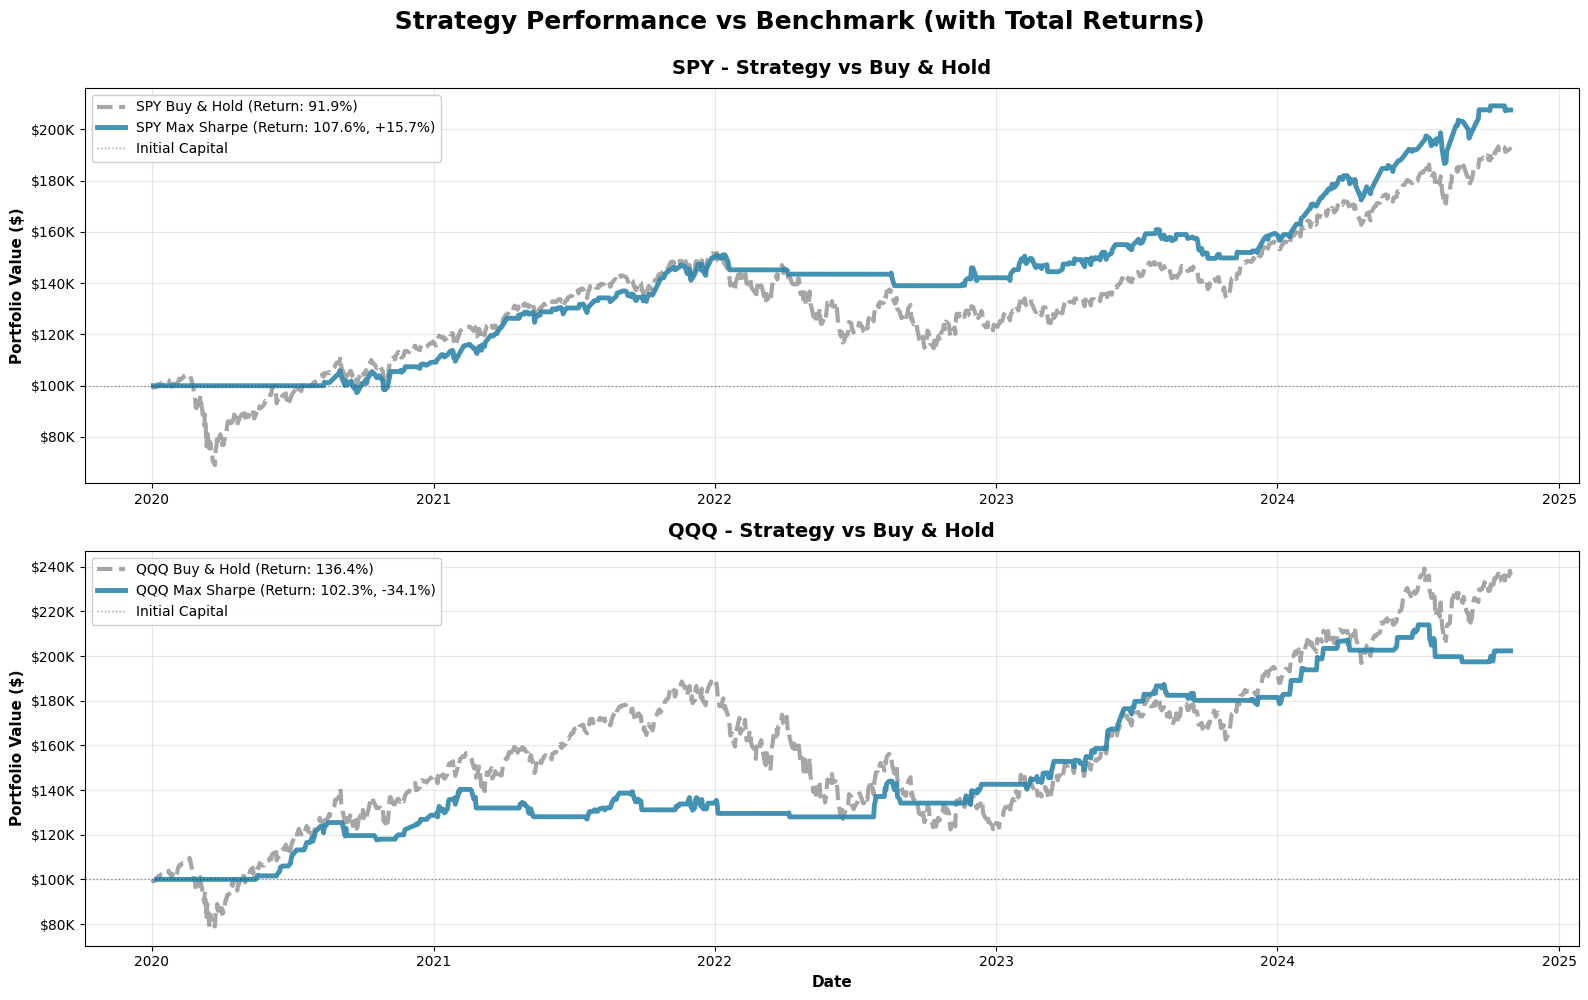


 Creating drawdown analysis per ticker...


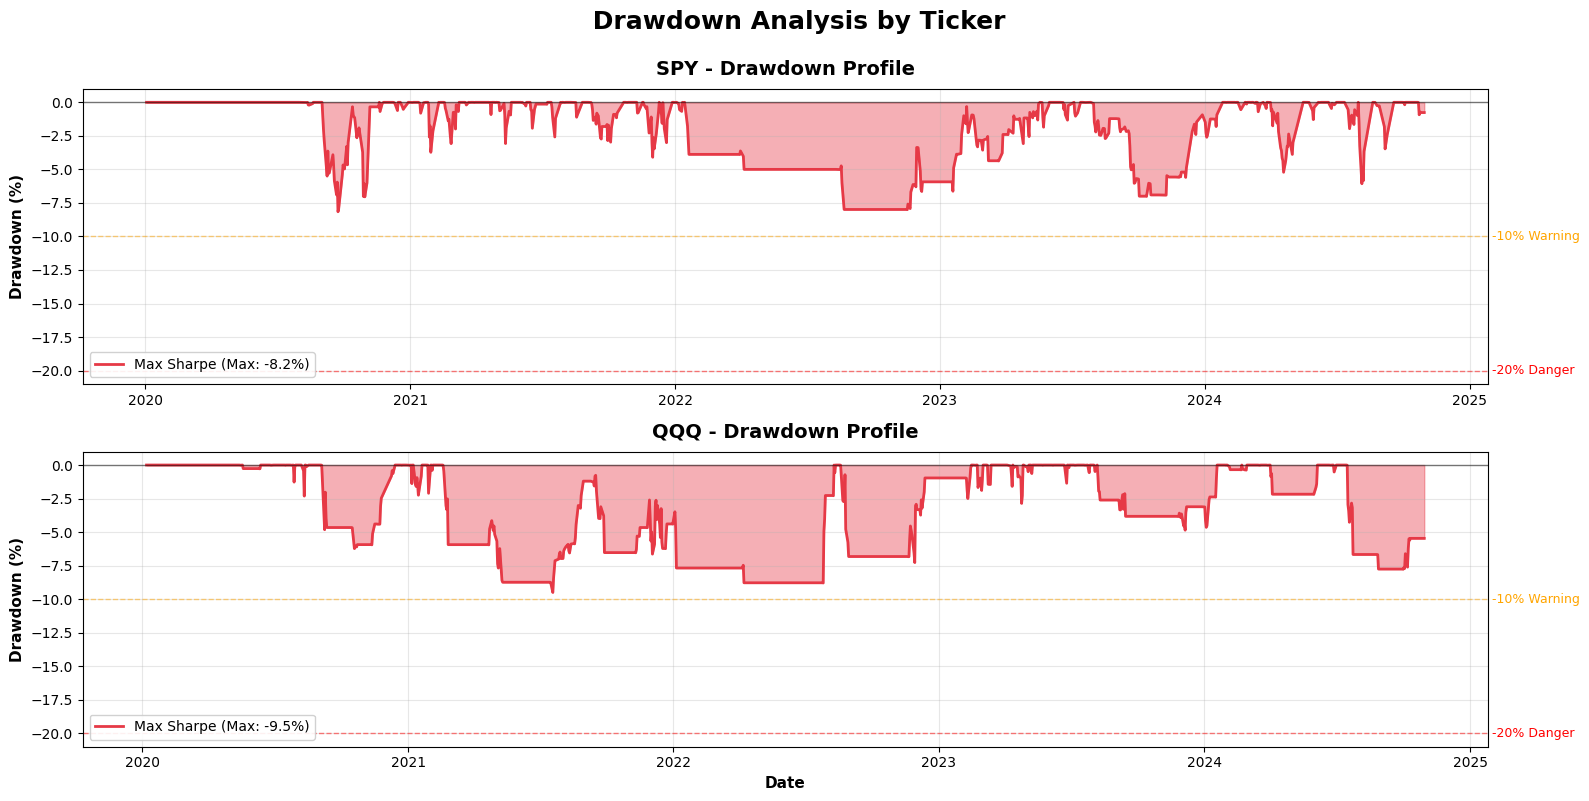

 Saved: drawdown_per_ticker.png

 Creating trades timeline...


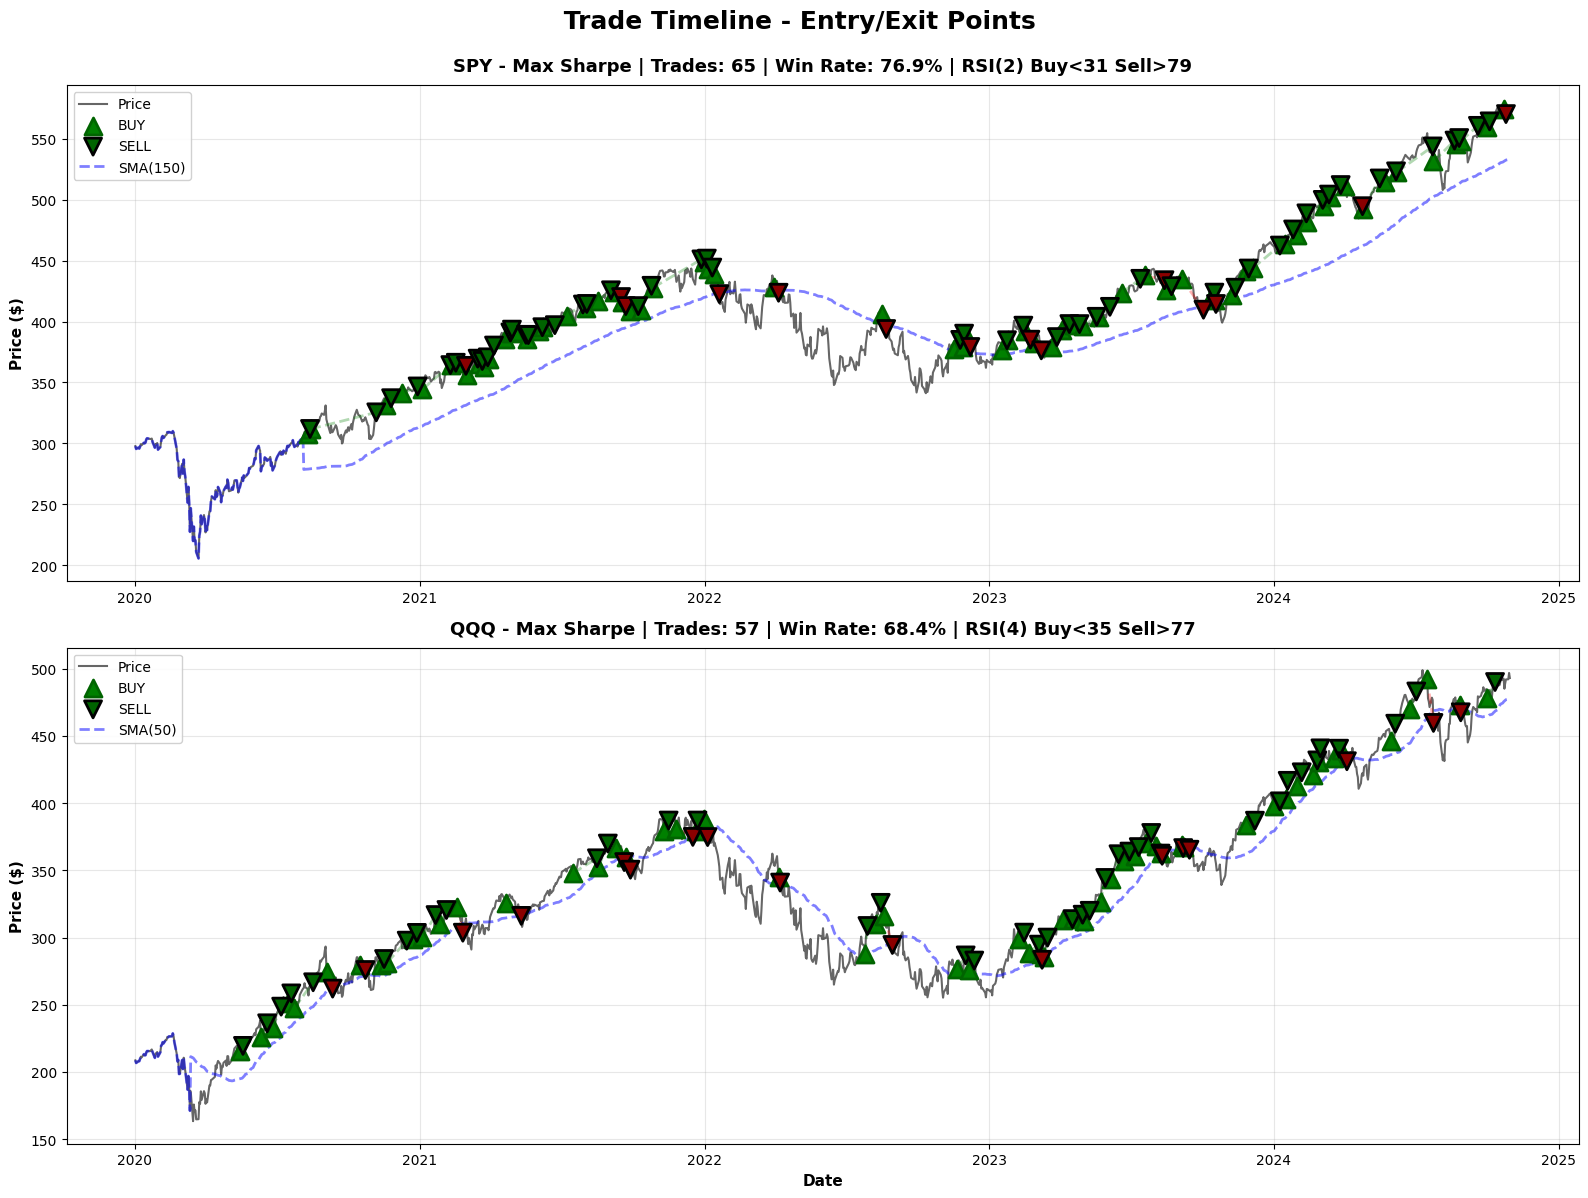


 Creating performance summary table...

 COMPREHENSIVE PERFORMANCE SUMMARY

 RANKED BY SHARPE RATIO (Best to Worst):
        Strategy   Sharpe  Return%  MaxDD%  WinRate%  ProfitFactor  AvgWin%  AvgLoss%  Trades  AvgDays  RSI_Per  RSI_Buy  RSI_Sell  SMA
SPY - Max Sharpe 1.726595   107.63   -8.16     76.12      3.199195     2.18     -2.18      67 6.044776        2       31        79  150
QQQ - Max Sharpe 1.533954   102.33   -9.50     67.24      2.558253     3.15     -2.53      58 5.034483        4       35        77   50

 Saved: performance_summary.csv

 AGGREGATE STATISTICS:
          Metric  Value
      Avg Sharpe   1.63
     Avg Return% 104.98
      Avg MaxDD%  -8.83
    Avg WinRate%  71.68
Avg ProfitFactor   2.88

 RUNNING WALK-FORWARD ANALYSIS (Out-of-Sample Testing)...

 Strategy #1: SPY - Max Sharpe
   Parameters: RSI(2) Buy<31 Sell>79 SMA(150)
   In-Sample Sharpe: 1.727
   In-Sample Return: 107.63%

 Running Walk-Forward Analysis for SPY...
   Data range: 2020-01-02 to 2024-10-

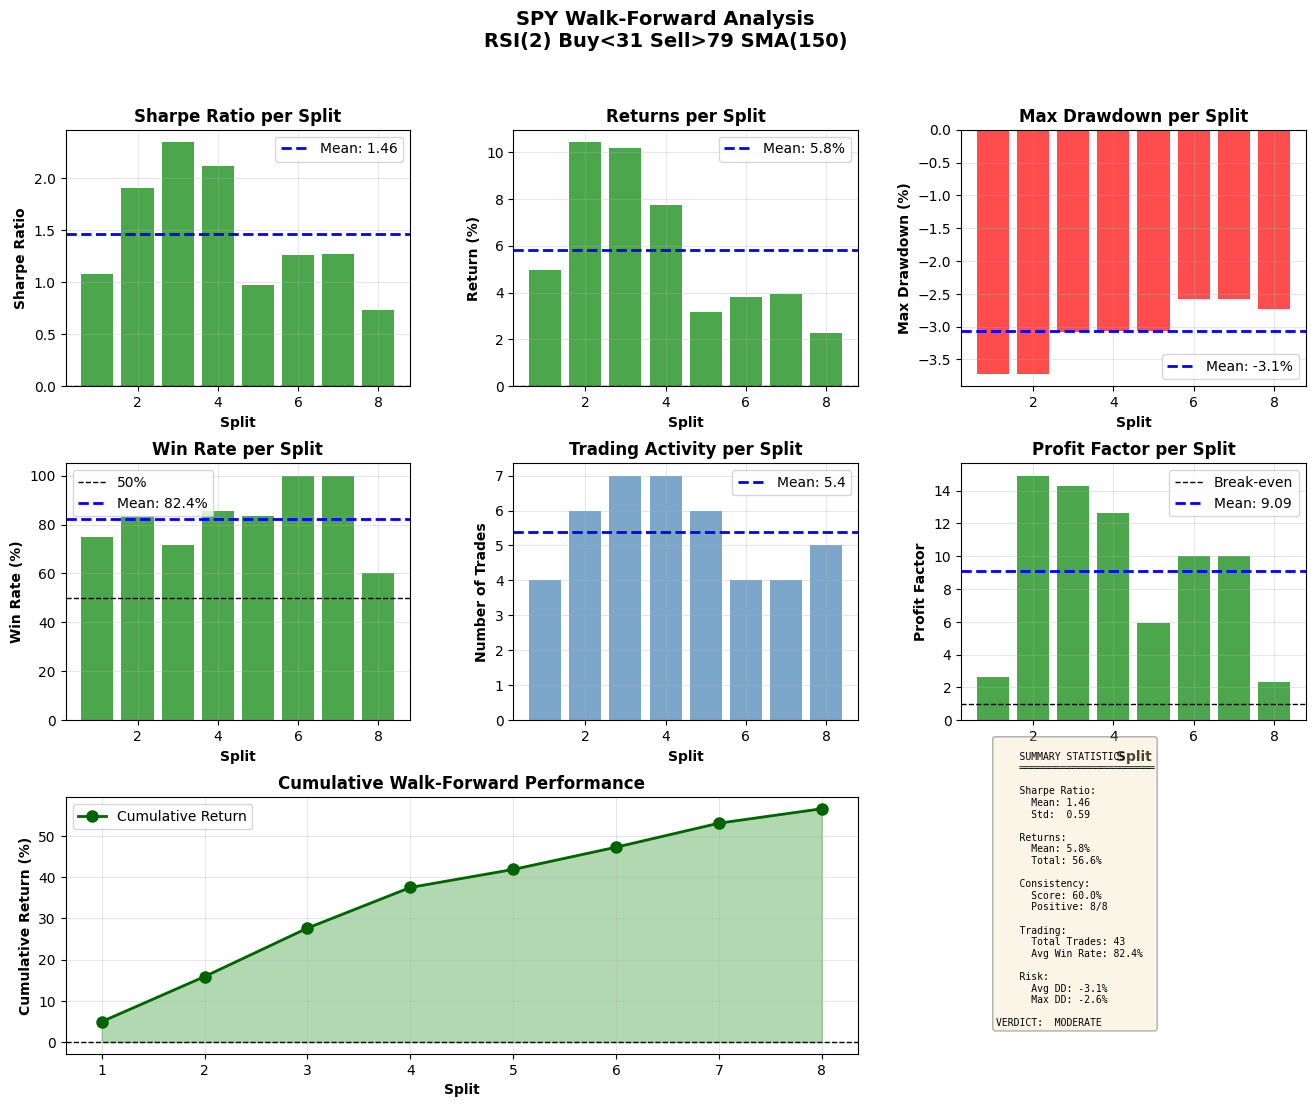


 Strategy #2: QQQ - Max Sharpe
   Parameters: RSI(4) Buy<35 Sell>77 SMA(50)
   In-Sample Sharpe: 1.534
   In-Sample Return: 102.33%

 Running Walk-Forward Analysis for QQQ...
   Data range: 2020-01-02 to 2024-10-30 (1216 days)
   Required lookback: 50 days (using 60 with buffer)
   Using STANDARD windows
   Train: 90 days, Test: 21 days, Step: 21 days
   Will create 8 splits (max possible: 50)
   Strategy: RSI(4) Buy<35 Sell>77 SMA(50)
   In-sample trades: 58
   Split 1: Train 2020-03-30 to 2020-08-05, Test 2020-08-06 to 2020-09-03
      (With lookback: Train=150 days, Test=81 days)
      ✓ Sharpe: 2.96, Return: 7.7%, Trades: 1
   Split 2: Train 2020-04-29 to 2020-09-03, Test 2020-09-04 to 2020-10-05
      (With lookback: Train=150 days, Test=81 days)
      ✓ Sharpe: -1.48, Return: -4.7%, Trades: 1
   Split 3: Train 2020-05-29 to 2020-10-05, Test 2020-10-06 to 2020-11-03
      (With lookback: Train=150 days, Test=81 days)
      ✓ Sharpe: -1.52, Return: -1.3%, Trades: 1
   Split 4: Tra

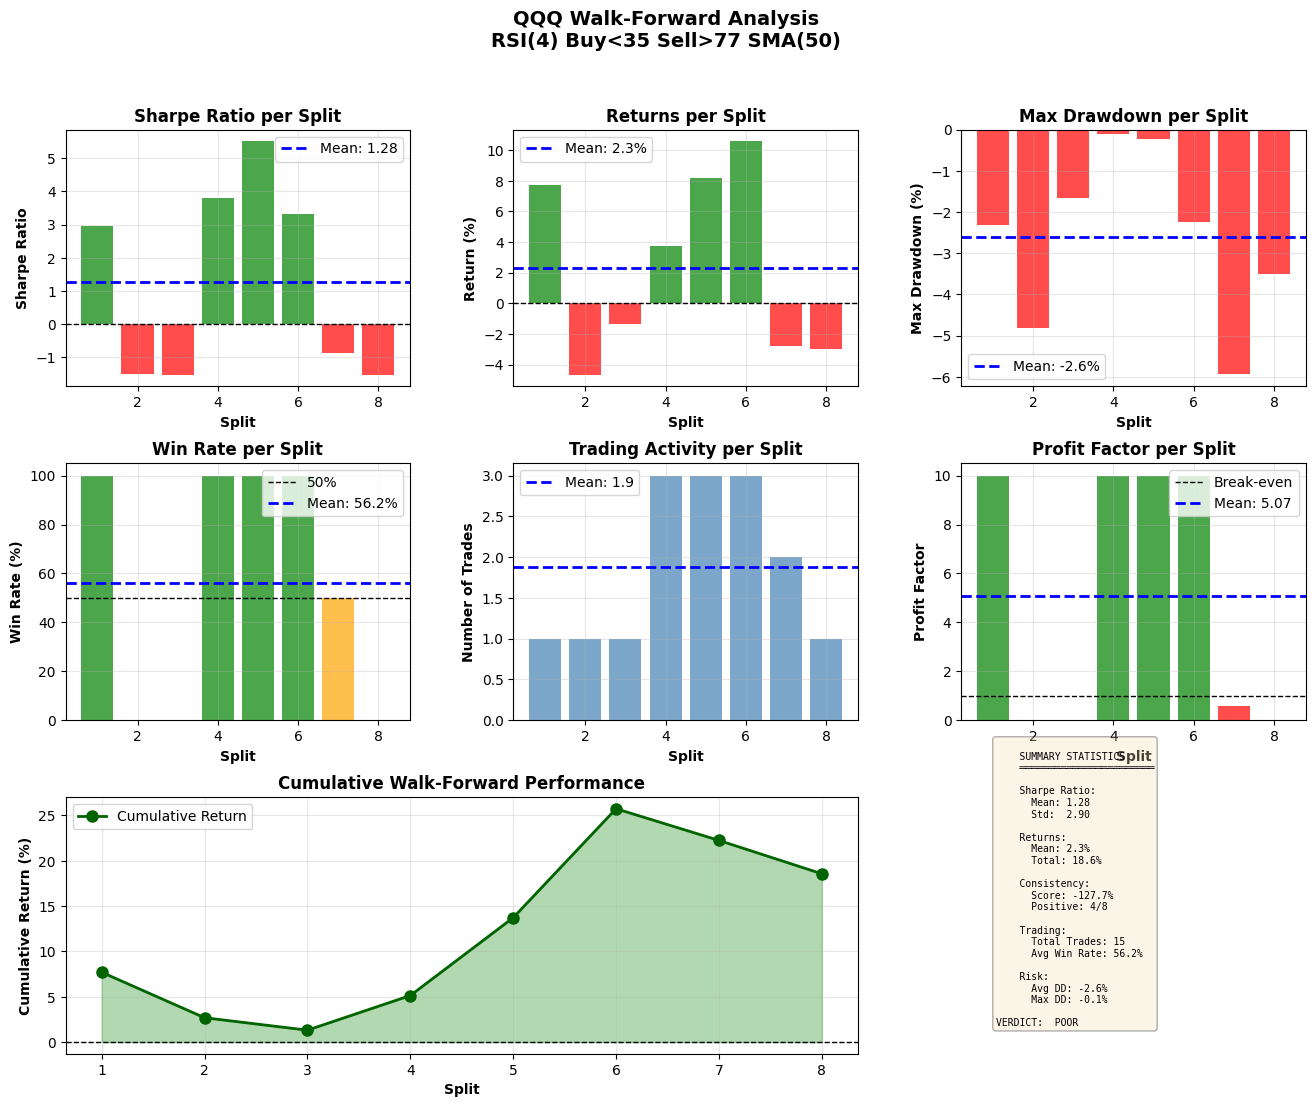


 CREATING COMPARATIVE WALK-FORWARD SUMMARY...
    Saved: walk_forward_comparison.png


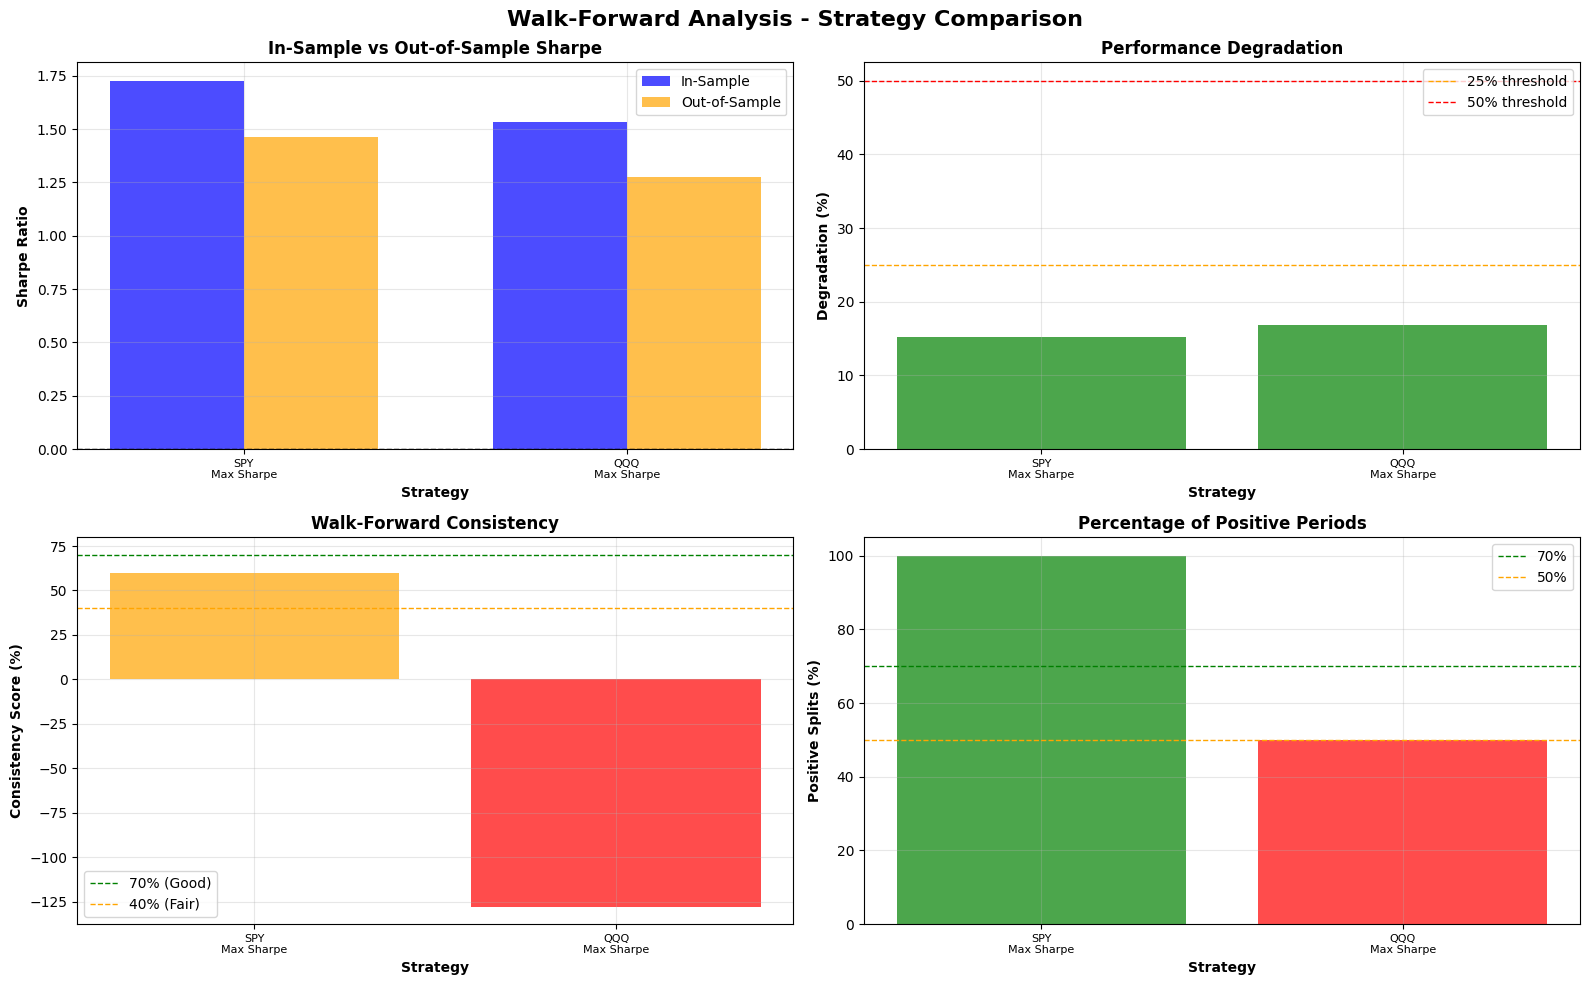


 WALK-FORWARD SUMMARY TABLE:
ticker strategy_type  in_sample_sharpe  oos_sharpe  degradation  consistency  positive_pct  total_trades
   SPY    Max Sharpe          1.726595    1.464011    15.208203         60.0         100.0            43
   QQQ    Max Sharpe          1.533954    1.275817    16.828225       -127.7          50.0            15

 ALL VISUALIZATIONS COMPLETE!


In [23]:
# ==================== MAIN VISUALIZATION EXECUTION (UPDATED) ====================

if len(final_strategies) > 0 and len(best_returns_data) > 0:
    print("\n" + "=" * 120)
    print(" GENERATING VISUALIZATIONS...")
    print("=" * 120)
    
    # Get list of tickers that have strategies
    available_tickers = [t for t in TICKERS if t in best_returns_data]
    
    if len(available_tickers) == 0:
        print(" No ticker data available for visualization")
    else:
        # 1. Equity curves per ticker (each ticker vs its own benchmark)
        print("\n Creating equity curves per ticker...")
        plot_equity_curves_per_ticker(best_returns_data, data_dict, available_tickers)
        
        # 2. Drawdown per ticker
        print("\n Creating drawdown analysis per ticker...")
        plot_drawdown_per_ticker(best_returns_data, available_tickers)
        
        # 3. Trades timeline
        print("\n Creating trades timeline...")
        plot_trades_timeline(data_dict, final_strategies)
        
        # 4. Performance summary table
        print("\n Creating performance summary table...")
        summary_table = create_performance_summary_table(final_strategies)
        
        # 5. Walk-Forward Analysis for ALL strategies
        print("\n" + "=" * 120)
        print(" RUNNING WALK-FORWARD ANALYSIS (Out-of-Sample Testing)...")
        print("=" * 120)
        
        # Store all walk-forward results for comparison
        all_wf_results = []
        
        for idx, (_, strategy) in enumerate(final_strategies.iterrows()):
            ticker = strategy['ticker']
            strategy_type = strategy['Strategy_Type']
            
            print(f"\n{'='*80}")
            print(f" Strategy #{idx+1}: {ticker} - {strategy_type}")
            print(f"{'='*80}")
            print(f"   Parameters: RSI({int(strategy['rsi_period'])}) "
                  f"Buy<{int(strategy['rsi_buy'])} "
                  f"Sell>{int(strategy['rsi_sell'])} "
                  f"SMA({int(strategy['sma_period'])})")
            print(f"   In-Sample Sharpe: {strategy['sharpe_ratio']:.3f}")
            print(f"   In-Sample Return: {strategy['total_return']*100:.2f}%")
            
            wf_results = walk_forward_analysis(
                data_dict[ticker],
                strategy,
                ticker,
                n_splits=8
            )
            
            if not wf_results.empty:
                print(f"\n Walk-Forward Results for {ticker} - {strategy_type}:")
                display_cols = ['split', 'sharpe', 'total_return', 'win_rate', 'max_drawdown', 'trades']
                print(wf_results[display_cols].to_string(index=False, float_format="%.3f"))
                
                # Calculate consistency metrics
                sharpe_std = wf_results['sharpe'].std()
                sharpe_mean = wf_results['sharpe'].mean()
                consistency = 1 - (sharpe_std / abs(sharpe_mean)) if sharpe_mean != 0 else 0
                
                positive_splits = len(wf_results[wf_results['sharpe'] > 0])
                total_splits = len(wf_results)
                
                print(f"\n Walk-Forward Performance:")
                print(f"   • Average Sharpe: {sharpe_mean:.3f}")
                print(f"   • Sharpe Std Dev: {sharpe_std:.3f}")
                print(f"   • Consistency Score: {consistency:.2%}")
                print(f"   • Positive Splits: {positive_splits}/{total_splits}")
                
                # Store for summary
                all_wf_results.append({
                    'ticker': ticker,
                    'strategy_type': strategy_type,
                    'in_sample_sharpe': strategy['sharpe_ratio'],
                    'oos_sharpe': sharpe_mean,
                    'oos_std': sharpe_std,
                    'consistency': consistency,
                    'positive_pct': positive_splits / total_splits,
                    'total_trades': wf_results['trades'].sum()
                })
                
                if consistency > 0.7 and positive_splits >= total_splits * 0.7:
                    print("    EXCELLENT - Strategy generalizes well to unseen data!")
                elif consistency > 0.4 and positive_splits >= total_splits * 0.5:
                    print("    MODERATE - Strategy shows some consistency but use caution")
                else:
                    print("    POOR - Strategy may be overfit to in-sample data")
                
                # Create enhanced visualization for EACH strategy
                print(f"\n Generating detailed visualization for {ticker}...")
                plot_walk_forward_results_enhanced(
                    wf_results, 
                    ticker, 
                    strategy,
                    save_path=f"walk_forward_{ticker}_{strategy_type}.png"
                )
                
            else:
                print(f" Insufficient data for walk-forward analysis on {ticker}")
        
        # 6. Create comparative summary chart
        if len(all_wf_results) > 1:
            print(f"\n{'='*80}")
            print(" CREATING COMPARATIVE WALK-FORWARD SUMMARY...")
            print(f"{'='*80}")
            
            wf_summary_df = pd.DataFrame(all_wf_results)
            
            fig, axes = plt.subplots(2, 2, figsize=(16, 10))
            fig.suptitle('Walk-Forward Analysis - Strategy Comparison', fontsize=16, fontweight='bold')
            
            # Plot 1: In-Sample vs Out-of-Sample Sharpe
            ax1 = axes[0, 0]
            x = range(len(wf_summary_df))
            width = 0.35
            ax1.bar([i - width/2 for i in x], wf_summary_df['in_sample_sharpe'], 
                   width, label='In-Sample', color='blue', alpha=0.7)
            ax1.bar([i + width/2 for i in x], wf_summary_df['oos_sharpe'], 
                   width, label='Out-of-Sample', color='orange', alpha=0.7)
            ax1.set_xlabel('Strategy', fontweight='bold')
            ax1.set_ylabel('Sharpe Ratio', fontweight='bold')
            ax1.set_title('In-Sample vs Out-of-Sample Sharpe', fontweight='bold')
            ax1.set_xticks(x)
            ax1.set_xticklabels([f"{r['ticker']}\n{r['strategy_type']}" 
                                for _, r in wf_summary_df.iterrows()], rotation=0, fontsize=8)
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
            
            # Plot 2: Degradation
            ax2 = axes[0, 1]
            degradation = ((wf_summary_df['in_sample_sharpe'] - wf_summary_df['oos_sharpe']) / 
                          wf_summary_df['in_sample_sharpe'] * 100)
            colors = ['green' if d < 25 else 'orange' if d < 50 else 'red' for d in degradation]
            ax2.bar(x, degradation, color=colors, alpha=0.7)
            ax2.axhline(y=25, color='orange', linestyle='--', linewidth=1, label='25% threshold')
            ax2.axhline(y=50, color='red', linestyle='--', linewidth=1, label='50% threshold')
            ax2.set_xlabel('Strategy', fontweight='bold')
            ax2.set_ylabel('Degradation (%)', fontweight='bold')
            ax2.set_title('Performance Degradation', fontweight='bold')
            ax2.set_xticks(x)
            ax2.set_xticklabels([f"{r['ticker']}\n{r['strategy_type']}" 
                                for _, r in wf_summary_df.iterrows()], rotation=0, fontsize=8)
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # Plot 3: Consistency Score
            ax3 = axes[1, 0]
            colors = ['green' if c > 0.7 else 'orange' if c > 0.4 else 'red' 
                     for c in wf_summary_df['consistency']]
            ax3.bar(x, wf_summary_df['consistency'] * 100, color=colors, alpha=0.7)
            ax3.axhline(y=70, color='green', linestyle='--', linewidth=1, label='70% (Good)')
            ax3.axhline(y=40, color='orange', linestyle='--', linewidth=1, label='40% (Fair)')
            ax3.set_xlabel('Strategy', fontweight='bold')
            ax3.set_ylabel('Consistency Score (%)', fontweight='bold')
            ax3.set_title('Walk-Forward Consistency', fontweight='bold')
            ax3.set_xticks(x)
            ax3.set_xticklabels([f"{r['ticker']}\n{r['strategy_type']}" 
                                for _, r in wf_summary_df.iterrows()], rotation=0, fontsize=8)
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            
            # Plot 4: Positive Split Percentage
            ax4 = axes[1, 1]
            colors = ['green' if p > 0.7 else 'orange' if p > 0.5 else 'red' 
                     for p in wf_summary_df['positive_pct']]
            ax4.bar(x, wf_summary_df['positive_pct'] * 100, color=colors, alpha=0.7)
            ax4.axhline(y=70, color='green', linestyle='--', linewidth=1, label='70%')
            ax4.axhline(y=50, color='orange', linestyle='--', linewidth=1, label='50%')
            ax4.set_xlabel('Strategy', fontweight='bold')
            ax4.set_ylabel('Positive Splits (%)', fontweight='bold')
            ax4.set_title('Percentage of Positive Periods', fontweight='bold')
            ax4.set_xticks(x)
            ax4.set_xticklabels([f"{r['ticker']}\n{r['strategy_type']}" 
                                for _, r in wf_summary_df.iterrows()], rotation=0, fontsize=8)
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('walk_forward_comparison.png', dpi=300, bbox_inches='tight')
            print("    Saved: walk_forward_comparison.png")
            plt.show()
            
            # Print summary table
            print("\n WALK-FORWARD SUMMARY TABLE:")
            print("="*100)
            summary_display = wf_summary_df.copy()
            summary_display['degradation'] = degradation
            summary_display['consistency'] = (summary_display['consistency'] * 100).round(1)
            summary_display['positive_pct'] = (summary_display['positive_pct'] * 100).round(1)
            
            print(summary_display[['ticker', 'strategy_type', 'in_sample_sharpe', 'oos_sharpe', 
                                   'degradation', 'consistency', 'positive_pct', 'total_trades']].to_string(index=False))
        
        print("\n" + "=" * 120)
        print(" ALL VISUALIZATIONS COMPLETE!")
        print("=" * 120)
        
else:
    print(" No strategies or returns data available for visualization")